The code is divided into two main components:

**Block class:** Implements a single residual block.

**ResNet class: ** Defines the overall ResNet architecture, assembling blocks into layers.

**Block Class**
This defines a single residual block in ResNet. Residual blocks solve the vanishing gradient problem by adding a **shortcut connection (identity mapping)**.
Initialization (Constructor)
**in_size: Number of input channels (feature maps).**
**out_size: Number of output channels.**
identity_downsample: A downsampling layer for the shortcut connection, applied when input/output sizes differ.
stride: Determines how much the input is reduced spatially (default is 1).

**First convolution layer for the input image**.

img_channels=1 : Number of channels in the input image (Gry scale).
kernel_size=7: A large kernel to extract broad spatial features.
stride=2: Reduces the spatial size by half.
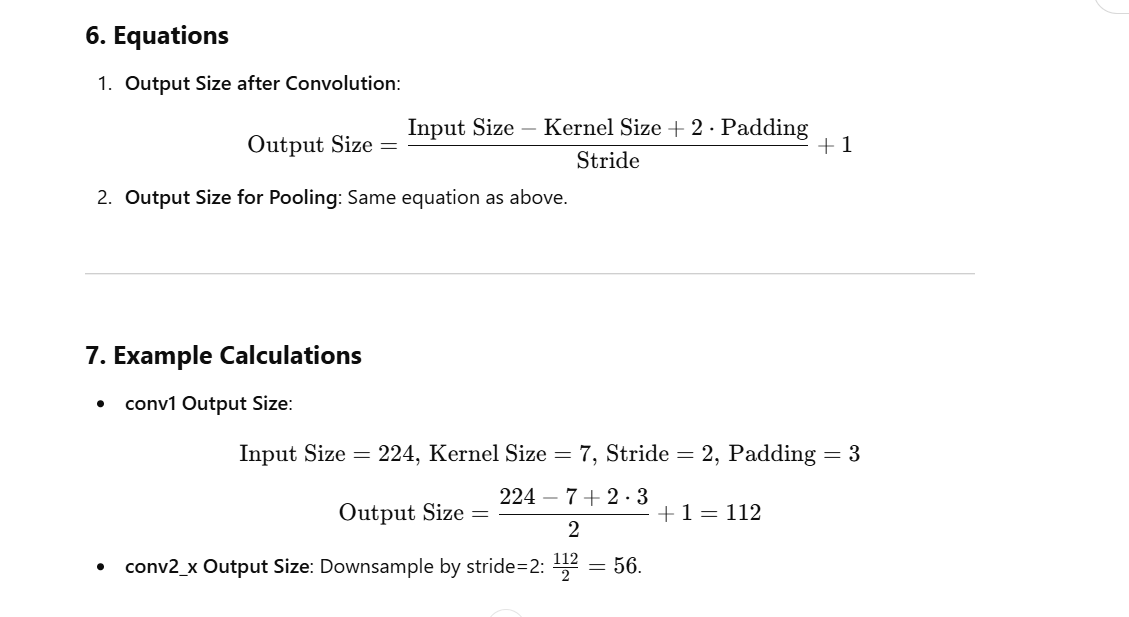

In [ ]:
from google.colab import drive
import os
import numpy as np
import nibabel as nib
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import matplotlib.pyplot as plt
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title Data Preparation
# min-max normalization
def normalize(x):
    return (x - x.min()) / (x.max() - x.min() + 1e-8)

def resize(image, target_shape=(64, 64, 64)):

    return F.interpolate(
        torch.tensor(image).unsqueeze(0).unsqueeze(0),  # add batch and channel dimensions the shape of the image should be : (batch size, chaneel, width, length, depth)
        size=target_shape
    ).squeeze(0).squeeze(0).numpy()  # Remove batch and channel dimensions


class MRIImageDataset(Dataset):
    def __init__(self, data_dir, label_map, transform=None):

        """
            data_dir: Path to the root directory containing subdirectories of images.
            label_map (dict): Mapping from class names ("CN", "MCI", "AD") to integer labels.
            transform: Transformations to apply to the images(normalize).
        """
        # to store the images and the corresponding integer label
        self.data = []
        self.labels = []
        self.transform = transform

        # looping over each label and collect file paths
        for label_name, label_value in label_map.items(): # label_map = {'cn': 0 ,'mci' : 1, 'ad' : 2}
            class_dir = os.path.join(data_dir, label_name, 'Preprocessed') # the folder that has the images for each categroy is named by the class name
            # folder for CN for example is : /content/drive/Shareddrives/ML_Data/3D_datasets/AD/Preprocessed
            for img_name in os.listdir(class_dir): # looping over the images in the folder of AD, CN, MCI
                    img_path = os.path.join(class_dir, img_name)
                    # saving the image and its corresponding integer label (0,1,2) which is the label_value
                    self.data.append(img_path)
                    self.labels.append(label_value)


    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
      """
      Retrieve an image and its label by index.
      """
      img_path = self.data[index]
      label = self.labels[index]
      image = np.array(nib.load(img_path).get_fdata(), dtype=np.float32)  # the Nifiti img is converted into 3d array
      image = self.transform(image)  # apply transformation

      # adding the channel dimension as : the correct shape for a single grayscale image is (1, depth, height, width)
      return torch.tensor(image).unsqueeze(0), label # this returns a tuple (image, label). the image first is converted from array to pytorch tensor, then
                                                         # .unsqueeze(0) : adds demnsion (1) as its gry scale


def prepare_data(data_dir, label_map, batch_size=16, test_size=0.2, val_size=0.2):
    # Transform with resizing to 64×64×64 and normalization
    transform = transforms.Compose([
        transforms.Lambda(lambda x: resize(x, target_shape=(64, 64, 64))),
        transforms.Lambda(normalize)
    ])


    dataset = MRIImageDataset(data_dir, label_map, transform=transform)

    indices = list(range(len(dataset)))
    train_val_indices, test_indices = train_test_split(
        indices, test_size=test_size, random_state=42
    )

    # split training+validation into training (80%) and validation (20%)
    train_size = int(len(train_val_indices) * (1 - val_size))
    val_size = len(train_val_indices) - train_size
    train_indices, val_indices = train_test_split(
        train_val_indices, test_size=val_size, random_state=42
    )

    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

    return train_loader, val_loader, test_loader

In [ ]:
#@title Basic Block for ResNet

class BasicBlock(nn.Module): # inhrting from nn.module

    def __init__(self, in_size, out_size, stride=1, downsample=None): #in_size is the number of chennels which is 1 (for gry scale) at the first
                                                                      # out_size the number of the desired channels (feature map)
        super(BasicBlock, self).__init__()
        # applying 2 convultion layers, BN, and activation function and downsample as for the identitfy maping both x and F(X) must have the same size
        self.conv1 = nn.Conv3d(in_size, out_size, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm3d(out_size)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(out_size, out_size, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm3d(out_size)
        self.downsample = downsample

# skip connection part
    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)
      # applying the trasnformations to the input
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        out += identity # adding x+F(x)
        out = self.relu(out)
        return out

In [ ]:
# ResNet Model
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=3):
        super(ResNet, self).__init__()
        self.in_size = 64
        self.conv1 = nn.Conv3d(1, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.make_layer(block, 64, layers[0])  # input: [16, 64, 16, 16, 16] → Output: [16, 64, 16, 16, 16] as here stride =1
        self.layer2 = self.make_layer(block, 128, layers[1], stride=2)  # input: [16, 64, 16, 16, 16] → Output: [16, 128, 8, 8, 8]
        self.layer3 = self.make_layer(block, 256, layers[2], stride=2)  # input: [16, 128, 8, 8, 8] → Output: [16, 256, 4, 4, 4]
        self.layer4 = self.make_layer(block, 512, layers[3], stride=2)  # input: [16, 256, 4, 4, 4] → Output: [16, 512, 2, 2, 2]
        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))  #  output: [16, 512, 1, 1, 1].
        self.dropout = nn.Dropout(p=0.3)  # 30% dropout
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, out_size, blocks, stride=1):

        """
            block (class): The type of residual block to use (BasicBlock).
            out_size (int): The number of output channels (feature maps) for this layer.
            blocks (int): The total number of residual blocks in the layer (2).
            stride: The stride for the first residual block in the layer. Default is 1.
        Returns:
            nn.Sequential: A sequential module containing all the residual blocks in this layer.
        """
        downsample = None  # initialize downsample as None.
        # define a downsampling layer if input/output dimensions differ or stride > 1.
        if stride != 1 or self.in_size != out_size:
            downsample = nn.Sequential(
                nn.Conv3d(self.in_size, out_size, kernel_size=1, stride=stride),  # 1x1 convolution.
                nn.BatchNorm3d(out_size)
            )

        # the first residual block.
        layers = [block(self.in_size, out_size, stride, downsample)]
        # updating the input size for subsequent blocks.
        self.in_size = out_size
        # add remaining residual blocks.
        for i in range(1, blocks):
            layers.append(block(self.in_size, out_size))
        # return the sequential module containing all blocks.
        return nn.Sequential(*layers)


    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

def ResNet18(num_classes=3):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

In [ ]:
#@title Training Logic

def train_model(model, train_loader, test_loader, num_epochs=20, learning_rate=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss() # the loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    history = {"train_loss": [], "val_loss": [], "train_accuracy": [], "val_accuracy": []}

    for epoch in range(num_epochs):
        model.train() # puts the model in training mode (activates certain layers like Dropout).
        running_loss, correct, total = 0, 0, 0

        '''
        running_loss: Tracks the total loss over the epoch.
        correct: Counts the number of correct predictions.
        total: Counts the total number of samples.
        '''
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs) # outputs is the model's prediction
            loss = criterion(outputs, labels)
            loss.backward() # computes gradients of the loss with respect to the model parameters.
            optimizer.step() # updates the model's parameters using the gradients.
            running_loss += loss.item() # extracts the scalar loss value for the batch and adds it to running_loss.
            values , indeces = outputs.max(1) # finds the predicted class with the highest probability.
            predicted = indeces
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_accuracy = 100 * correct / total
        history["train_loss"].append(running_loss / len(train_loader))
        history["train_accuracy"].append(train_accuracy)

        model.eval()  # Set the model to evaluation mode
        val_loss, correct, total = 0, 0, 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                values, indices= outputs.max(1)
                predicted = indices
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_accuracy = 100 * correct / total
        history["val_loss"].append(val_loss / len(test_loader))
        history["val_accuracy"].append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss/len(train_loader):}, Train Acc: {train_accuracy:}%, Val Loss: {val_loss/len(test_loader):}, Val Acc: {val_accuracy:}%")

    return history

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_and_plot(model, test_loader, history, num_classes=3, class_names=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    all_preds, all_labels = [], []

    # collect predictions and true labels
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            all_preds.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    predictions = np.concatenate(all_preds)
    true_labels = np.concatenate(all_labels)
    predicted_classes = np.argmax(predictions, axis=1)

    # Plot Training and Validation Accuracies
    plt.figure(figsize=(12, 6))
    plt.plot(history["train_accuracy"], label="Train Accuracy")
    plt.plot(history["val_accuracy"], label="Validation Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Training and Validation Losses
    plt.figure(figsize=(12, 6))
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Validation Loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

    # Compute ROC curve and AUC for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    one_hot_labels = np.eye(num_classes)[true_labels]
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(one_hot_labels[:, i], predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC Curve
    plt.figure(figsize=(12, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

    # Plot Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.colorbar()
    plt.show()

    # Print Classification Report
    print("\nClassification Report:")
    print(classification_report(true_labels, predicted_classes))

<ipython-input-32-6f4f8822c71c>:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image).unsqueeze(0), label


Epoch 1/50, Train Loss: 0.9868, Train Acc: 54.62%, Val Loss: 1.2198, Val Acc: 31.82%
Epoch 2/50, Train Loss: 0.5615, Train Acc: 78.15%, Val Loss: 1.1672, Val Acc: 31.82%
Epoch 3/50, Train Loss: 0.1388, Train Acc: 96.64%, Val Loss: 1.4006, Val Acc: 31.82%
Epoch 4/50, Train Loss: 0.1399, Train Acc: 94.96%, Val Loss: 1.1586, Val Acc: 40.91%
Epoch 5/50, Train Loss: 0.0601, Train Acc: 97.48%, Val Loss: 1.2513, Val Acc: 54.55%
Epoch 6/50, Train Loss: 0.0377, Train Acc: 99.16%, Val Loss: 1.8019, Val Acc: 50.00%
Epoch 7/50, Train Loss: 0.1099, Train Acc: 94.96%, Val Loss: 1.1099, Val Acc: 54.55%
Epoch 8/50, Train Loss: 0.0395, Train Acc: 99.16%, Val Loss: 1.2514, Val Acc: 77.27%
Epoch 9/50, Train Loss: 0.3077, Train Acc: 90.76%, Val Loss: 1.1465, Val Acc: 50.00%
Epoch 10/50, Train Loss: 0.4181, Train Acc: 87.39%, Val Loss: 1.6088, Val Acc: 63.64%
Epoch 11/50, Train Loss: 0.1134, Train Acc: 97.48%, Val Loss: 0.8332, Val Acc: 68.18%
Epoch 12/50, Train Loss: 0.1441, Train Acc: 94.12%, Val Loss: 0

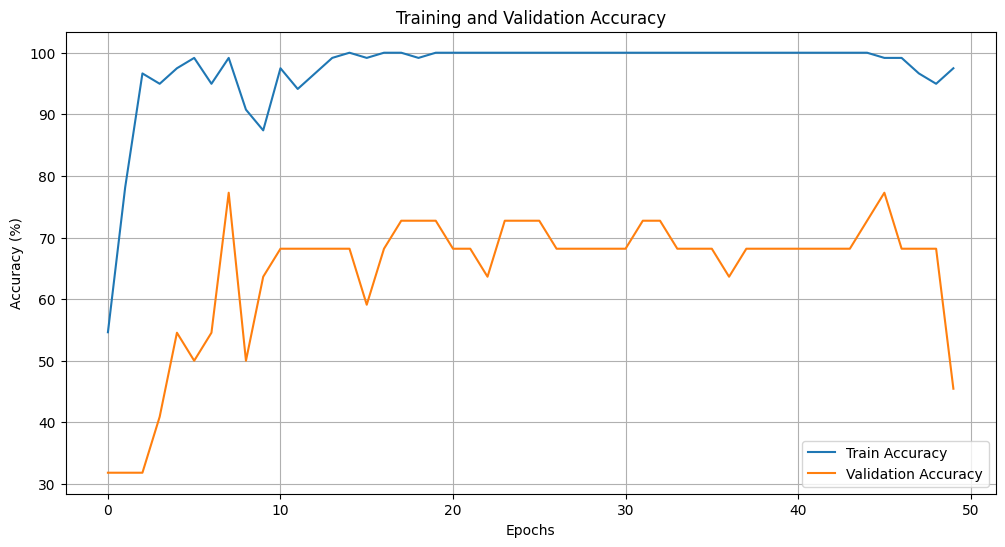

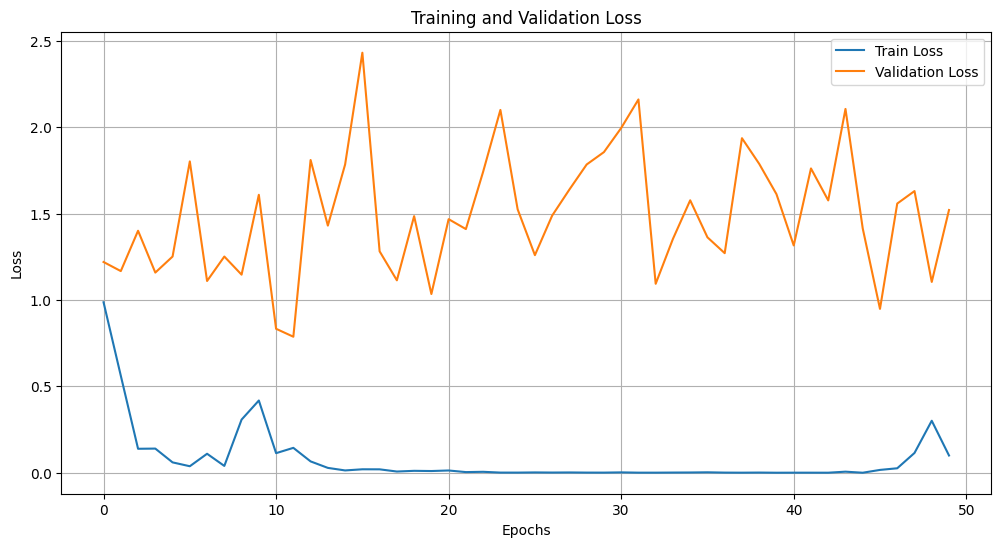

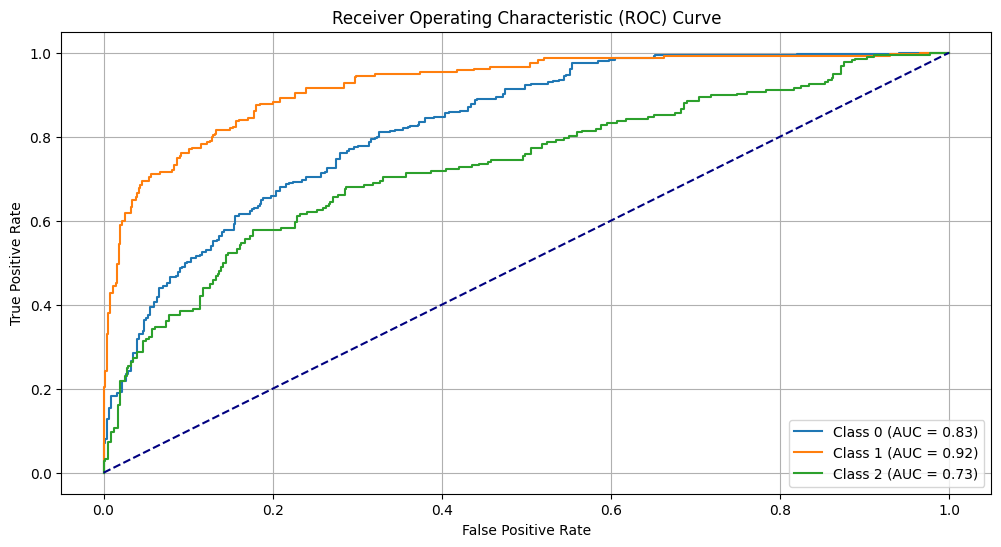

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

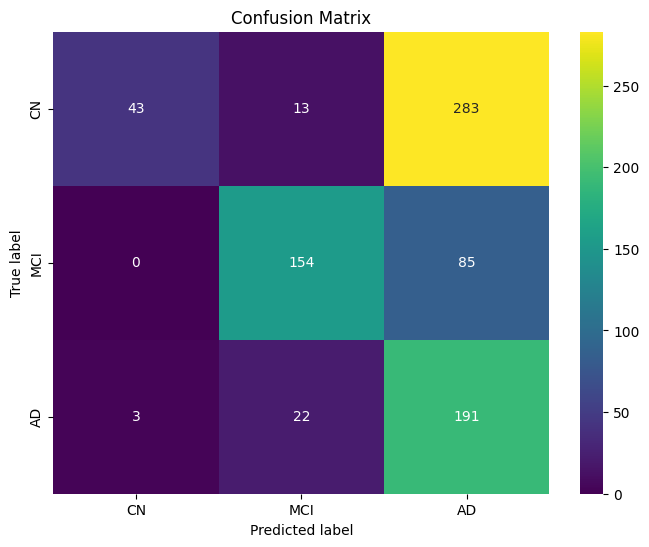

In [ ]:
#@title workflow
data_dir = '/content/drive/Shareddrives/ML_Data/3D_datasets'
label_map = {"CN": 0, "MCI": 1, "AD": 2}
train_loader, val_loader, test_loader = prepare_data(data_dir, label_map, batch_size=16)
model = ResNet18(num_classes=3)
history = train_model(model, train_loader, val_loader, num_epochs= 50)
evaluate_and_plot(model, test_loader, history, class_names= label_map.keys())